In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

c:\Users\cynthia\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
print("Current working directory:", os.getcwd())

Current working directory: d:\msib\bangkit\capstone\grape


In [3]:
# Path ke dataset
DATA_DIR = './'

# Subdirektori untuk masing-masing kelas
data_dir_Black_Rot = os.path.join(DATA_DIR, 'train', 'Black Rot')
data_dir_ESCA = os.path.join(DATA_DIR, 'train', 'ESCA')
data_dir_Healthy = os.path.join(DATA_DIR, 'train', 'Healthy')
data_dir_Leaf_Blight = os.path.join(DATA_DIR, 'train', 'Leaf Blight')

# Hitung jumlah gambar di setiap kelas pada folder train
print(f"There are {len(os.listdir(data_dir_Black_Rot))} images of Black Rot.")
print(f"There are {len(os.listdir(data_dir_ESCA))} images of ESCA.")
print(f"There are {len(os.listdir(data_dir_Healthy))} images of Healthy plants.")
print(f"There are {len(os.listdir(data_dir_Leaf_Blight))} images of Leaf Blight.")

There are 700 images of Black Rot.
There are 700 images of ESCA.
There are 700 images of Healthy plants.
There are 700 images of Leaf Blight.


In [4]:
import tensorflow as tf
import os

def train_val_datasets():
    # Load training and validation datasets from the main directory
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='./train',
        image_size=(150, 150),
        batch_size=32,
        label_mode='categorical',
        validation_split=0.2,  # 20% data untuk validasi
        subset='training',
        seed=42
    )
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='./test',
        image_size=(150, 150),
        batch_size=32,
        label_mode='categorical',
        validation_split=0.2,  # 20% data untuk validasi
        subset='validation',
        seed=42
    )

    return training_dataset, validation_dataset

# Memanggil fungsi dan memeriksa data
train_dataset, val_dataset = train_val_datasets()
print(f"Training dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")


Found 2800 files belonging to 4 classes.
Using 2240 files for training.
Found 1692 files belonging to 4 classes.
Using 338 files for validation.
Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [5]:
# Get the first batch of images and labels
for images, labels in train_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 251.4998016357422

Shape of batch of images: (32, 150, 150, 3)
Shape of batch of labels: (32, 4)


In [6]:
# GRADED FUNCTION: create_augmentation_model
def create_augmentation_model():
    
    augmentation_model = tf.keras.Sequential([ 
        tf.keras.layers.Input(shape=(150, 150, 3)),
		tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1)
    ]) 
    

    return augmentation_model

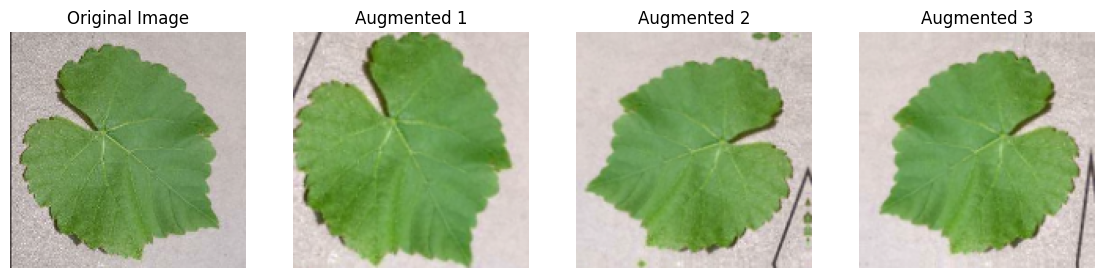

In [7]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [8]:
model = tf.keras.models.Sequential()

augmentation_layers = create_augmentation_model()

model.add(augmentation_layers)
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
# 512 neuron hidden layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

c:\Users\cynthia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Gunakan 'sparse_categorical_crossentropy' jika label numerik
    metrics=['accuracy']
)

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Gunakan 'sparse_categorical_crossentropy' jika label numerik
    metrics=['accuracy']
)

In [10]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 4)


history = model.fit(
    training_dataset,
    epochs = 10, 
    validation_data = validation_dataset 
)

In [11]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.85 and logs.get('val_accuracy') >= 0.85:
            self.model.stop_training = True
            # print("\nReached 80% train accuracy and 80% validation accuracy, stopping training!")

In [12]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 422ms/step - accuracy: 0.3760 - loss: 296.6074 - val_accuracy: 0.6450 - val_loss: 0.9249
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 387ms/step - accuracy: 0.6353 - loss: 0.9355 - val_accuracy: 0.7308 - val_loss: 0.7250
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 370ms/step - accuracy: 0.7141 - loss: 0.7283 - val_accuracy: 0.7485 - val_loss: 0.6341
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 392ms/step - accuracy: 0.6806 - loss: 0.8257 - val_accuracy: 0.7396 - val_loss: 0.8911
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 410ms/step - accuracy: 0.6875 - loss: 0.8313 - val_accuracy: 0.6331 - val_loss: 1.0223
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 375ms/step - accuracy: 0.7296 - loss: 0.7663 - val_accuracy: 0.7574 - val_loss: 0.6442
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 374ms/step - accuracy: 0.7108 - loss: 0.7590 - val_accuracy: 0.7663 - val_loss: 0.6867
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 356ms/step - accuracy: 0.7300 - loss: 0.7655 - val_ac

In [13]:
# Evaluasi model
loss, accuracy = model.evaluate(val_dataset)
print(f'Loss: {loss}, Accuracy: {accuracy}')

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8359 - loss: 0.4885 

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8425 - loss: 0.4968
Loss: 0.4304303824901581, Accuracy: 0.860946774482727


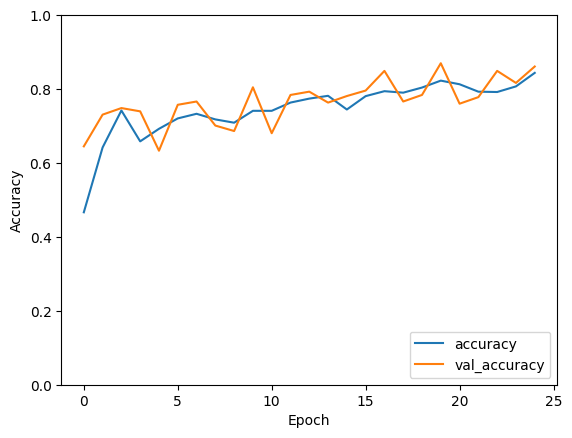

In [14]:
# Visualisasi hasil pelatihan
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [15]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [16]:
from ipywidgets import widgets
from io import BytesIO
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction}')
        
        prediction_index = np.argmax(prediction)
        
        classes = ["Black Rot", "ESCA", "Healthy", "Leaf Blight"]
        
        predicted_class = classes[prediction_index]
        
        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [17]:
# Save the model
model.save("grape_model.h5")
print("Model saved as 'grape_model.h5'.")

Model saved as 'grape_model.h5'.


In [ ]:
model.save("saved_model/my_model")

In [ ]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
# Save the model
model.save("grape_model.h5")
print("Model saved as 'grape_model.h5'.")

In [ ]:
# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/my_model")
tflite_model = converter.convert()

# Simpan model TFLite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
W0000 00:00:1733321518.112420 10949490 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733321518.112440 10949490 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-04 21:11:58.112624: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model/
2024-12-04 21:11:58.112892: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-04 21:11:58.112897: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: saved_model/
2024-12-04 21:11:58.114886: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-04 21:11:58.125820: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: saved_model/
2024-12-04 21:11:58.129682: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 17059 microseconds.


3108